In [1]:
import idx2numpy
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
import joblib

In [2]:
df = pd.read_csv('/Users/ramyanee/Downloads/ML/Assignment2/OVO_RECORDS2.csv')
mappings = []
for i in range(len(df)):
    x = (pd.concat([df['class 1'],df['class 2']],axis=1)).iloc[i][0]
    y = (pd.concat([df['class 1'],df['class 2']],axis=1)).iloc[i][1]
    mappings.append([x,y])


In [19]:
def confusionMatrix(y,ypred):
    d = len(np.unique(y))
    mat = np.zeros((d,d))

    for i in range(len(y)):
            mat[y[i]][ypred[i]]+=1
    return mat


In [20]:
#utility functions
def mse(yhat,y):
    err = 0
    for i in range(len(y)):
        err = err + (yhat[i]-y[i])**2
    return err/len(y)
def acc_(predictions,testSet_y):
  test_size = len(testSet_y)
  # testSet_y = list(testSet_y)
  correct_predictions = 0
  for i in range(test_size):
    if testSet_y[i]==predictions[i]:
      correct_predictions= correct_predictions+1
  return (correct_predictions/test_size)*100
def normalise_(data_):
    desc = data_.describe()
    for col in desc.columns.unique():
        xmean = desc[col][1]
        sigma = desc[col][2]
        if sigma != 0:
            data_[col] = (data_[col]-xmean)/sigma
    return data_
def kfoldsplit(k,data,target):
    
    splits = []
    
    y = pd.DataFrame(data[target])
    x = data.drop(target,axis=1)
    d = []
    s = int(len(data)/k)
    
    for i in range(k):
        a = s*i
        b = a+s
        d.append([a,b])
    for [a,b] in d:
        
        
        x_test = x[a:b]
        y_test = np.array(y[a:b][target])
        x_train = pd.concat([x[:a],x[b:]])
        y_train = np.array(pd.concat([y[:a],y[b:]])[target])
        splits.append([x_train,y_train,x_test,y_test])
    
    return splits
def _sigmoid_(arg):
    return (1/(1+np.exp(-arg)))

def loss(yreal,ypred):
    return np.mean(-yreal*np.log(ypred)-(1-yreal)*np.log(1-ypred)) 



In [21]:
class LogRegression(object):
    """docstring for LogRegression."""
    def __init__(self, arg):
        super(LogRegression, self).__init__()
        self.arg = arg

    def fit_ovr(self,arg):
        
        df,Y,l2,alpha,epochs = arg
        OVRdata = df.copy()
        OVRdata = OVRdata.sample(frac=1)
        labels = np.unique(Y)
        ovr_records = []
        clfno = 0
        for l in labels:
            R = OVRdata.copy()
            if l == 0:
                R.loc[R['Y']==0,'Y']=float('inf')
                R.loc[R['Y']!=float('inf'),'Y']=0
                R.loc[R['Y']==float('inf'),'Y']=1
            elif l==1:
                R.loc[R['Y']==1,'Y']=float('inf')
                R.loc[R['Y']!=float('inf'),'Y']=0
                R.loc[R['Y']==float('inf'),'Y']=1
            else:
                R.loc[R['Y']!=l,'Y']=0
                R.loc[R['Y']==l,'Y']=1

            lr = LogRegression(None)
            xtrain,xtest,ytrain,ytest = train_test_split(R.drop('Y',axis=1),R.Y,shuffle=True,test_size=0.33)
            xtrain = normalise_(xtrain)
            xtest = normalise_(xtest)
            xtrain = np.array(xtrain).T
            xtest = np.array(xtest).T
            ytrain = np.array(ytrain)
            ytest = np.array(ytest)
            lr.fit([xtrain,ytrain,xtest,ytest,epochs,alpha,l2])
            joblib.dump(lr,f"ovrclassifiers/{clfno}.pkl")
            clfno+=1

            ytestp = lr.predict(xtest)
            ytrainp = lr.predict(xtrain)

            tsa = acc_(ytestp,ytest)
            tra = acc_(ytrainp,ytrain)

            L_train = lr.lossestr
            L_test = lr.lossests
            ovr_records.append([l,tsa,tra,L_train,L_test])
            print([l,tsa,tra])
        OVR_RECORDS =  pd.DataFrame(ovr_records, columns=[['selected class','Test Accuracy','Train Accuracy','Training Loss','Test Loss']])
        return OVR_RECORDS        

    def fit_ovo(self,arg):
        mappings = []
        clfno = 0
        df,Y,l2,alpha,epochs = arg

        labels = np.unique(Y)
        CLASSES = []
        for l in labels:
            CLASSES.append(df[df['Y']==l])

        ovo_records = []
        for l in labels:
            a = CLASSES[l].copy()
            a.Y =a.Y.replace([l],[1])
            print(f"l is {l}")
            next_l = l+1
            others = CLASSES[next_l:].copy()

            for c in range(len(others)):
                curr_l = next_l+c
                print(f"c {c} is curr_l is {curr_l}")
                b = others[c].copy()
                actuallabel = b['Y'].iloc[0]
                b.Y = b.Y.replace([actuallabel],[0])
                data = pd.concat([a,b])
                data = data.sample(frac=1)

                xtrain,xtest,ytrain,ytest = train_test_split(data.drop('Y',axis=1),data.Y,shuffle=True)

                # for i in range(len(S)):
                lr = LogRegression(None)
                    # xtrain,ytrain,xtest,ytest = S[i]
                xtrain = normalise_(xtrain)
                xtest = normalise_(xtest)
                xtrain = np.array(xtrain).T
                xtest = np.array(xtest).T
                ytrain = np.array(ytrain)
                ytest = np.array(ytest)
                lr.fit([xtrain,ytrain,xtest,ytest,epochs,alpha,l2])
                joblib.dump(lr,f"ovoclassifiers/{clfno}.pkl")
                clfno+=1
                mappings.append([l,actuallabel])
                ytestp = lr.predict(xtest)
                ytrainp = lr.predict(xtrain)
                tsa = acc_(ytestp,ytest)
                tra = acc_(ytrainp,ytrain)

                L_train = lr.lossestr
                L_test = lr.lossests
                ovo_records.append([l,actuallabel,tsa,tra,L_train,L_test])
                print(f'{[l,actuallabel,tsa,tra]}')
        OVO_RECORDS= pd.DataFrame(ovo_records, columns=[['class 1','class 2','Test Accuracy','Train Accuracy','Training Loss','Test Loss']])
        return [OVO_RECORDS,mappings]
        

        
    def fit(self,arg):
        
        xtrain,ytrain,xtest,ytest,no_epochs,alpha,l2 = arg
        n = xtrain.shape[1]
        d = xtrain.shape[0]
        theta = np.zeros((d,1))
        bias = 0
        lossestr = []
        lossests = []

        for e in range(no_epochs):
            print(f"epoch: {e+1}")
            # print(( np.dot(x, np.array(theta).reshape(d,1))).shape)
           
            yhat=_sigmoid_( np.dot(xtrain.T,theta)+ bias)
            
            ythat=_sigmoid_(np.dot(xtest.T,theta)+ bias)
            yhat = yhat.reshape(yhat.shape[0])
            ythat = ythat.reshape(ythat.shape[0])


            G,db= gradient(xtrain,ytrain,yhat,l2,theta)
            
            theta -= alpha*G.reshape((d,1))
            self.weights = theta
            bias= (bias - alpha*db)
            # print(bias.shape)
            self.B = bias

            lossestr.append(loss(ytrain,yhat))
            lossests.append(loss(ytest,ythat))
        
        self.lossestr = lossestr
        self.lossests = lossests

    def getProba(self,xtest):
        p = _sigmoid_( np.dot(xtest.T,self.weights)+ self.B)
        return p

    def predict(self,X_test):
        # d = len(X_test.columns.unique())
        p = _sigmoid_( np.dot(X_test.T,self.weights)+ self.B)
        predictedValues = []
        for i in p:
            if i[0]>=0.5:
                predictedValues.append(1)
            else:
                predictedValues.append(0)
        y_predicted = predictedValues
        return y_predicted
    def get_mse(self,xtest,ytest):
        p = _sigmoid_( np.dot(xtest.T,self.weights)+ self.B)
        return mse(p,ytest)


In [22]:

def gradient(xtrain,ytrain,yhat,l2,theta):
    
    theta = theta.reshape(theta.shape[0])
    s = 0
    for i in range(len(xtrain.T)):
        s+=((yhat[i]-ytrain[i])*xtrain.T[i])
    cost =  s
    reg = theta*l2
    delTheta =  (cost+reg)
    delTheta = delTheta/len(xtrain.T)
    delBias = np.sum(yhat-ytrain)
    delBias = delBias/len(xtrain.T)
    # print(f"delbias={delBias.shape}")
    #print(delTheta.shape)
    return delTheta,delBias

In [23]:
XTRAIN= idx2numpy.convert_from_file('/Users/ramyanee/Downloads/ML/Assignment2/MNSIT/train-images.idx3-ubyte')
YTRAIN= idx2numpy.convert_from_file('/Users/ramyanee/Downloads/ML/Assignment2/MNSIT/train-labels.idx1-ubyte')
XTEST= idx2numpy.convert_from_file('/Users/ramyanee/Downloads/ML/Assignment2/MNSIT/t10k-images.idx3-ubyte')
YTEST= idx2numpy.convert_from_file('/Users/ramyanee/Downloads/ML/Assignment2/MNSIT/t10k-labels.idx1-ubyte')

In [24]:
X = np.concatenate((XTRAIN,XTEST),axis = 0)
Y = np.concatenate((YTRAIN,YTEST),axis = 0) 

In [25]:
data = pd.DataFrame(zip(XTRAIN,Y))

In [26]:
import matplotlib.pyplot as plt
def visualise(c,X,Y):
 for j in range(len(c)):
    count=0 
    fig, axes = plt.subplots(1, 5, figsize=(8, 8))
    for i in range(len(X)):
      if(count==5):
        break
      if(Y[i]==j):
        axes[count].imshow(X[i])
        count=count+1  
    
    plt.tight_layout()

        

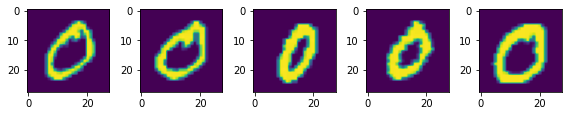

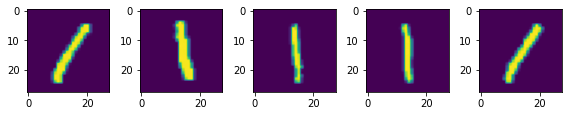

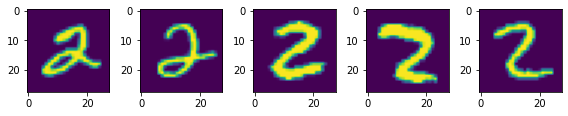

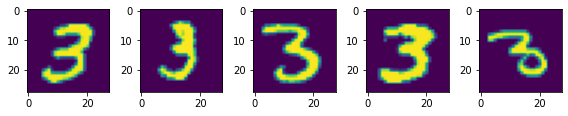

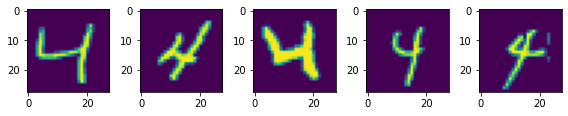

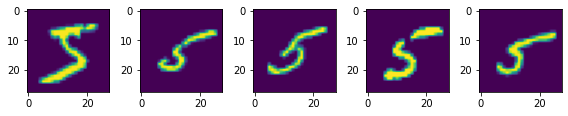

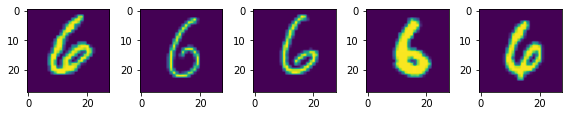

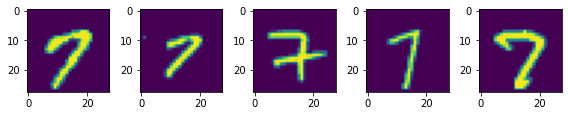

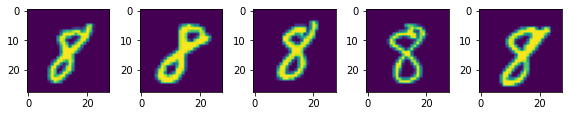

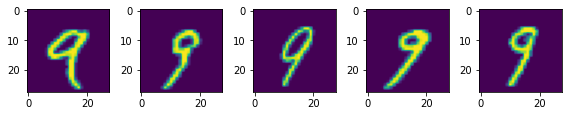

In [27]:
visualise(np.unique(YTRAIN),XTRAIN,YTRAIN)

move normalisation down, dont normalise again.

In [28]:
#preparing the data
D = []
DT = []

for i in range(len(XTRAIN)):
    D.append(XTRAIN[i].flatten().reshape((1,784)))


for i in range(len(XTEST)):
    DT.append(XTEST[i].flatten().reshape((1,784)))
    
f= np.array(D).reshape(60000,784)
XDF = pd.DataFrame(f)
XDF['Y'] = YTRAIN

XDFTest = pd.DataFrame(np.array(DT).reshape(10000,784))
XDFTest['Y'] = YTEST

XDF = XDF.sample(frac=1)
XDFTest = XDFTest.sample(frac=1)
#xtrain,xtest,ytrain,ytest = train_test_split(XDF.copy().drop('Y',axis = 1),XDF.copy().Y,test_size = 1/7,shuffle=True)

In [29]:
df = XDF.copy()

In [14]:
# lrovo = LogRegression(None)
# OVO_RECORDS,mappings = lrovo.fit_ovo([df,Y,0,0.01,200])

l is 0
c 0 is curr_l is 1
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epo

In [30]:
xtest = normalise_(XDFTest.drop('Y',axis=1))
xtest = np.array(xtest).T
ytest = np.array(XDFTest.Y)
xtrain = normalise_(XDF.drop('Y',axis=1))
xtrain = np.array(xtrain).T
ytrain = np.array(XDF.Y)

In [31]:
classesPredicted = []
classesTPredicted = []
for i in range(len(mappings)):
    # print(f"classifier = {i}")
    # print(f"mapping = {mappings[i]}")
    # print(OVO_RECORDS.iloc[i].T)
    classPredicted = []
    classTPredicted = []
    clf = joblib.load(f"ovoclassifiers/{i}.pkl")
    predictions = clf.predict(xtest)
    p_train = clf.predict(xtrain)
    for p in predictions:
        if p==1:
            classPredicted.append(mappings[i][0])
        else:
            classPredicted.append(mappings[i][1])
    for p in p_train:
        if p==1:
            classTPredicted.append(mappings[i][0])
        else:
            classTPredicted.append(mappings[i][1])
    classesPredicted.append(classPredicted)
    classesTPredicted.append(classTPredicted)

In [32]:
Predictions = pd.DataFrame(classesPredicted)
PredictionsT = pd.DataFrame(classesTPredicted)

In [33]:
yPredicted = []
for col in Predictions.columns:
    yPredicted.append(Predictions[col].mode()[0])
yPredicted = np.array(yPredicted)

yPredictedT = []
for col in PredictionsT.columns:
    yPredictedT.append(PredictionsT[col].mode()[0])
yPredictedT = np.array(yPredictedT)


In [34]:
def count(array):
    c = 0
    for a in array:
        if a==True:
            c+=1
    return c

In [35]:
cm = confusionMatrix(ytest,yPredicted).astype(int)
cmT = confusionMatrix(ytrain,yPredictedT).astype(int)

In [36]:
accuraciesOvO = []
for i in range(len(cm)):
    accuraciesOvO.append(cm[i][i]/np.sum(cm[i]))
accuraciesOvOT = []
for i in range(len(cmT)):
    accuraciesOvOT.append(cmT[i][i]/np.sum(cmT[i]))
            
    


In [37]:
classwiseAccOVO_Test=pd.DataFrame(accuraciesOvO)
classwiseAccOVO_Test

,0
0,0.986735
1,0.993833
2,0.813953
3,0.852475
4,0.925662
5,0.679372
6,0.949896
7,0.921206
8,0.652977
9,0.785927


In [38]:
classwiseAccOVO_Train=pd.DataFrame(accuraciesOvOT)
classwiseAccOVO_Train

,0
0,0.982948
1,0.992139
2,0.830816
3,0.839667
4,0.909620
5,0.662977
6,0.955221
7,0.939665
8,0.616476
9,0.765003


In [35]:
ovoTotalAccuracyTest = acc_(yPredicted,ytest)
ovoTotalAccuracyTest

85.97

In [36]:
ovoTotalAccuracyTrain = acc_(yPredictedT,ytrain)
ovoTotalAccuracyTrain

85.35833333333333

In [37]:
OVO_RECORDS

,class 1,class 2,Test Accuracy,Train Accuracy,Training Loss,Test Loss
0,0,1,99.778971,99.768372,"[0.6931471805599453, 0.4992675831741463, 0.386...","[0.6931471805599451, 0.5009569796094543, 0.388..."
1,0,2,98.720969,98.496072,"[0.6931471805599453, 0.5812704008384227, 0.500...","[0.6931471805599454, 0.5809522791843577, 0.499..."
2,0,3,98.971466,98.993363,"[0.6931471805599453, 0.5821620719121224, 0.501...","[0.6931471805599454, 0.5821013510127131, 0.501..."
3,0,4,99.490143,99.376629,"[0.6931471805599453, 0.5633421078438566, 0.472...","[0.6931471805599454, 0.5628404929818666, 0.471..."
4,0,5,97.496474,98.225200,"[0.6931471805599453, 0.6148748381282332, 0.553...","[0.6931471805599453, 0.6156317433555483, 0.554..."
5,0,6,98.615333,98.750000,"[0.6931471805599453, 0.5757905838938302, 0.493...","[0.6931471805599454, 0.574926814439145, 0.4915..."
6,0,7,99.343617,99.573351,"[0.6931471805599453, 0.5454491249497148, 0.447...","[0.6931471805599453, 0.5462817860338558, 0.448..."
7,0,8,98.403533,98.561721,"[0.6931471805599453, 0.586432333172675, 0.5078...","[0.6931471805599453, 0.5860326774629894, 0.507..."
8,0,9,99.022911,99.101527,"[0.6931471805599453, 0.5561420065973761, 0.463...","[0.6931471805599453, 0.5570923057237328, 0.464..."
9,1,2,98.110236,98.299213,"[0.6931471805599453, 0.5766395333817562, 0.494...","[0.6931471805599453, 0.5789476272639437, 0.497..."


In [38]:
OVO_RECORDS.to_csv('OVO_RECORDS2.csv')

In [39]:
lrovr = LogRegression(None)
df=XDF.copy()
OVR_RECORDS= lrovr.fit_ovr([df,Y,0.01,0.1,50])

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
[0, 96.43939393939394, 96.47512437810946]
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch:

In [42]:
p_list = []
p_listT = []

for i in np.unique(ytest):
    clf = joblib.load(f"ovrclassifiers/{i}.pkl")
    probabilities = clf.getProba(xtest)
    p_list.append(probabilities)
    probabilities = clf.getProba(xtrain)
    p_listT.append(probabilities)




In [43]:
p_list=np.array(p_list)
p_listT=np.array(p_listT)

In [45]:
p_list=p_list.reshape(10,10000)
p_listT=p_listT.reshape(10,60000)

In [46]:
pd.DataFrame(p_list)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.273197,0.145078,0.103191,0.148730,0.151111,0.043927,0.085457,0.441447,0.975270,0.214166,...,0.117124,0.399989,0.096979,0.287895,0.314303,0.107505,0.083814,0.897767,0.138517,0.451582
1,0.794458,0.225450,0.077830,0.209229,0.457786,0.082417,0.827798,0.866260,0.149273,0.157717,...,0.974541,0.157810,0.234506,0.143810,0.461162,0.085181,0.871171,0.053427,0.116841,0.024995
2,0.106524,0.076658,0.270064,0.116260,0.156997,0.165878,0.266100,0.176511,0.232397,0.194740,...,0.158715,0.127594,0.231093,0.913176,0.370455,0.123713,0.397838,0.203092,0.123391,0.245335
3,0.143980,0.895545,0.149207,0.999779,0.173460,0.199133,0.181426,0.117764,0.293862,0.123378,...,0.208626,0.922499,0.198089,0.252127,0.302509,0.740804,0.192501,0.113017,0.098096,0.187150
4,0.116114,0.115110,0.458094,0.186548,0.301799,0.166979,0.366462,0.050997,0.205674,0.147439,...,0.162866,0.060959,0.173333,0.074869,0.164407,0.113802,0.214247,0.030424,0.192406,0.113989
5,0.266721,0.236290,0.144926,0.175891,0.157489,0.108466,0.117195,0.457570,0.186371,0.196132,...,0.144382,0.214421,0.212596,0.189541,0.121297,0.235084,0.100698,0.441624,0.236161,0.070282
6,0.269457,0.164095,0.128195,0.183237,0.130454,0.095685,0.107993,0.118209,0.050404,0.117132,...,0.158488,0.165439,0.147924,0.116257,0.046927,0.103659,0.126462,0.062009,0.207271,0.135624
7,0.174023,0.370197,0.159776,0.072946,0.100599,0.999904,0.247767,0.149338,0.177553,0.928351,...,0.157042,0.232297,0.235018,0.326000,0.097572,0.279326,0.134119,0.197353,0.853043,0.113478
8,0.300643,0.175563,0.225964,0.038710,0.136964,0.212807,0.226765,0.302147,0.140616,0.115667,...,0.142459,0.095246,0.818320,0.169976,0.699938,0.676888,0.275017,0.747778,0.160249,0.942492
9,0.147976,0.063564,0.821975,0.129212,0.780211,0.163946,0.151913,0.112052,0.089886,0.421628,...,0.191966,0.079482,0.122072,0.099750,0.105877,0.105445,0.183506,0.163268,0.525377,0.277901


In [47]:
preds = np.argmax(p_list,axis=0)
predsT = np.argmax(p_listT,axis=0)

   

In [48]:
ovrTotalAccuracyTest = acc_(preds,ytest)
ovrTotalAccuracyTrain = acc_(predsT,ytrain)

In [53]:
ovrTotalAccuracyTest

86.00999999999999

In [54]:
ovrTotalAccuracyTrain

85.33500000000001

In [49]:
cm = confusionMatrix(ytest,preds).astype(int)
cmT = confusionMatrix(ytrain,predsT).astype(int)

In [50]:
accuraciesOvr = []
for i in range(len(cm)):
    accuraciesOvr.append(cm[i][i]/np.sum(cm[i]))
accuraciesOvrT = []
for i in range(len(cmT)):
    accuraciesOvrT.append(cmT[i][i]/np.sum(cmT[i]))

In [51]:
accuraciesOvR= pd.DataFrame(accuraciesOvr)
accuraciesOvR

,0
0,0.968367
1,0.975330
2,0.812016
3,0.866337
4,0.902240
5,0.732063
6,0.912317
7,0.883268
8,0.758727
9,0.765114


In [52]:
accuraciesOvRT= pd.DataFrame(accuraciesOvrT)
accuraciesOvRT

,0
0,0.962012
1,0.972412
2,0.812689
3,0.832654
4,0.895413
5,0.716104
6,0.923285
7,0.885874
8,0.739703
9,0.763994


In [55]:
OVR_RECORDS

,selected class,Test Accuracy,Train Accuracy,Training Loss,Test Loss
0,0,96.439394,96.475124,"[0.6931471805599452, 0.5762009550963209, 0.541...","[0.6931471805599453, 0.5754517468316437, 0.540..."
1,1,96.196970,95.997512,"[0.6931471805599452, 0.595579505614624, 0.5607...","[0.6931471805599453, 0.5919226716700944, 0.556..."
2,2,96.121212,96.300995,"[-16.76450598793094, -9.223080681659027, -7.12...","[-17.25754440940784, -9.643751240108664, -7.50..."
3,3,95.191919,94.977612,"[-17.492827801534222, -10.346152328225646, -8....","[-17.329239632932417, -10.296759398541505, -8...."
4,4,96.429293,96.517413,"[-16.482005405684816, -11.067885597447908, -8....","[-16.79152545649804, -11.395387540021911, -9.2..."
5,5,95.868687,95.778607,"[-14.981221062502287, -11.786435707309622, -10...","[-16.06561131831162, -12.670093099735311, -10...."
6,6,96.904040,97.064677,"[-16.901342207456402, -8.284214742930207, -5.6...","[-16.62124930062715, -8.193414261307586, -5.64..."
7,7,95.550505,95.524876,"[-18.15935261277117, -8.484344578997408, -6.33...","[-17.17688728294268, -7.947880448190471, -5.90..."
8,8,94.707071,94.898010,"[-16.640911983198258, -12.806662618640903, -10...","[-16.549554077102563, -12.638639159125256, -10..."
9,9,94.848485,94.828358,"[-17.077905071360227, -11.525052591497921, -10...","[-16.540592174161993, -11.177334873687913, -9...."


In [56]:
OVR_RECORDS['Test Accuracy'].max()

Test Accuracy    96.90404
dtype: float64

In [57]:
OVR_RECORDS.describe()

,selected class,Test Accuracy,Train Accuracy
count,10.00000,10.000000,10.000000
mean,4.50000,95.825758,95.836318
std,3.02765,0.731397,0.771495
min,0.00000,94.707071,94.828358
25%,2.25000,95.281566,95.114428
50%,4.50000,95.994949,95.888060
75%,6.75000,96.371212,96.431592
max,9.00000,96.904040,97.064677


In [58]:
PerformanceTable = []
PerformanceTable.append(['OneVsOne_implemented',ovoTotalAccuracyTest,ovrTotalAccuracyTrain])
PerformanceTable.append(['OneVsRest_implemented',ovrTotalAccuracyTest,ovrTotalAccuracyTrain])


In [59]:

xtrainsk,xtestsk,ytrainsk,ytestsk = train_test_split(XDF.drop('Y',axis=1),XDF.Y,test_size=0.33,shuffle=True)
xtrainsk =preprocessing.normalize(xtrainsk)
xtestsk = preprocessing.normalize(xtestsk)
clfovo = OneVsOneClassifier(LogisticRegression(penalty='l2',max_iter=100)).fit(xtrainsk,ytrainsk)  
yh=clfovo.predict(xtestsk)
clfovo.score(xtestsk,ytestsk)
# clf.get_params()


0.9261616161616162

In [60]:
clfovr = OneVsRestClassifier(LogisticRegression(penalty='l2',max_iter=100)).fit(xtrainsk,ytrainsk)  
clfovr.score(xtestsk,ytestsk)

0.9056060606060606

In [61]:
PerformanceTable.append(['OneVsOne_sklearn',
        clfovo.score(xtestsk,ytestsk)*100,
        clfovo.score(xtrainsk,ytrainsk)*100])
PerformanceTable.append(['OneVsRest_sklearn',
        clfovr.score(xtestsk,ytestsk)*100,
        clfovr.score(xtrainsk,ytrainsk)*100])

In [62]:
PerformanceTable = pd.DataFrame(PerformanceTable,columns=['Estimator','Test Accuracy','Train Accuracy'])

In [63]:
PerformanceTable

,Estimator,Test Accuracy,Train Accuracy
0,OneVsOne_implemented,85.970000,85.335000
1,OneVsRest_implemented,86.010000,85.335000
2,OneVsOne_sklearn,92.616162,93.325871
3,OneVsRest_sklearn,90.560606,91.231343


In [1]:
!git add .
!git commit -m "q3 finishing off"
!git push -u origin main

[main ad1fe9f] q3 finishing off
 81 files changed, 15170 insertions(+)
 create mode 100644 A2_MT21139_RamyaneeKashyap/.DS_Store
 create mode 100644 A2_MT21139_RamyaneeKashyap/Assignment 2ML.pdf
 create mode 100644 A2_MT21139_RamyaneeKashyap/README.md
 create mode 100644 A2_MT21139_RamyaneeKashyap/ovoclassifiers/0.pkl
 create mode 100644 A2_MT21139_RamyaneeKashyap/ovoclassifiers/1.pkl
 create mode 100644 A2_MT21139_RamyaneeKashyap/ovoclassifiers/10.pkl
 create mode 100644 A2_MT21139_RamyaneeKashyap/ovoclassifiers/11.pkl
 create mode 100644 A2_MT21139_RamyaneeKashyap/ovoclassifiers/12.pkl
 create mode 100644 A2_MT21139_RamyaneeKashyap/ovoclassifiers/13.pkl
 create mode 100644 A2_MT21139_RamyaneeKashyap/ovoclassifiers/14.pkl
 create mode 100644 A2_MT21139_RamyaneeKashyap/ovoclassifiers/15.pkl
 create mode 100644 A2_MT21139_RamyaneeKashyap/ovoclassifiers/16.pkl
 create mode 100644 A2_MT21139_RamyaneeKashyap/ovoclassifiers/17.pkl
 create mode 100644 A2_MT21139_RamyaneeKashyap/ovoclassifiers